In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score
import lightgbm as lgb

# Adjust this path to point to your project's root directory
project_root = Path('../')
sys.path.append(str(project_root))

from src.data import read_data
from src.utils import preprocess

# load data
separation_thresholds = {'0-3': 1.3, '3-6': 1.3, '6+': 2.2}
range_offaxis = '0-3'
results = read_data(separation_thresholds, folder='full_negatives', suffix='')
df_pos = results[range_offaxis]['df_pos']
df_neg = results[range_offaxis]['df_neg']

In [2]:
# combine positive and negative samples
df_combined = pd.concat([df_pos, df_neg], axis=0)

# sort the dataframe by cscs21_name to ensure data is ordered by query
df_combined = df_combined.sort_values('csc21_name')

# create group sizes
group_sizes = df_combined.groupby('csc21_name').size()

# preprocess data
X_train, X_test, y_train, y_test, indices_train, indices_test, cat_features, _ = preprocess(df_pos, df_neg, model_type='lgbm')

In [3]:
# split group sizes into train and test
train_size = len(X_train)
groups_train = df_combined.iloc[indices_train].groupby('csc21_name').size().values
groups_test = df_combined.iloc[indices_test].groupby('csc21_name').size().values

# prepare datasets
train_data = lgb.Dataset(X_train, y_train, group=groups_train)
test_data = lgb.Dataset(X_test, y_test, group=groups_test, reference=train_data)

In [4]:
train_size, sum(groups_train)

(2530421, 2530421)

In [5]:
# set parameters for learning to rank
params = {
    'objective': 'lambdarank',
    'metric': [''],
    'eval_at': [1, 3, 5],
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'is_unbalance': True
}

# train model
model = lgb.train(params, train_data, num_boost_round=200, valid_sets=[test_data])



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6240
[LightGBM] [Info] Number of data points in the train set: 2530421, number of used features: 32


/home/vdiaz/.conda/envs/starsml/lib/python3.9/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/vdiaz/.conda/envs/starsml/lib/python3.9/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's ndcg@1: 0.813125	valid_0's ndcg@3: 0.846729	valid_0's ndcg@5: 0.860391
[2]	valid_0's ndcg@1: 0.844489	valid_0's ndcg@3: 0.868257	valid_0's ndcg@5: 0.87955
[3]	valid_0's ndcg@1: 0.85131	valid_0's ndcg@3: 0.874221	valid_0's ndcg@5: 0.884537
[4]	valid_0's ndcg@1: 0.85486	valid_0's ndcg@3: 0.877487	valid_0's ndcg@5: 0.888033
[5]	valid_0's ndcg@1: 0.855919	valid_0's ndcg@3: 0.878749	valid_0's ndcg@5: 0.889117
[6]	valid_0's ndcg@1: 0.857695	valid_0's ndcg@3: 0.880251	valid_0's ndcg@5: 0.890519
[7]	valid_0's ndcg@1: 0.858193	valid_0's ndcg@3: 0.881438	valid_0's ndcg@5: 0.891571
[8]	valid_0's ndcg@1: 0.859221	valid_0's ndcg@3: 0.882097	valid_0's ndcg@5: 0.892425
[9]	valid_0's ndcg@1: 0.859875	valid_0's ndcg@3: 0.882944	valid_0's ndcg@5: 0.893058
[10]	valid_0's ndcg@1: 0.860622	valid_0's ndcg@3: 0.883758	valid_0's ndcg@5: 0.894086
[11]	valid_0's ndcg@1: 0.861027	valid_0's ndcg@3: 0.8838	valid_0's ndcg@5: 0.894518
[12]	valid_0's ndcg@1: 0.861744	valid_0's ndcg@3: 0.885325	valid_0's

In [118]:
y_pred = model.predict(X_test)

In [10]:
df = pd.read_parquet('../scripts/benchmark_results_x100_negatives.parquet')

In [11]:
df.groupby('csc21_name')

In [ ]:
from src.utils import transform_features

# Step 2: Transform features for all test data at once
final_test, _ = transform_features(df, log_transform=False, model_type='lgbm')

# Step 3: Create a DataFrame with transformed features and true labels
results_df = pd.DataFrame(final_test)
results_df['csc21_name'] = df['csc21_name']
results_df['true_label'] = df['match_flag']

# Step 4: Process each group
binary_predictions = []
true_labels = []

for name, group in results_df.groupby('csc21_name'):
    # Get features for this group
    group_features = group.drop(['csc21_name', 'true_label'], axis=1)
    
    # Make predictions for this group
    group_predictions = model.predict(group_features)
    
    # Consider the highest-ranked item as the positive prediction
    max_pred_index = np.argmax(group_predictions)
    group_binary_pred = np.zeros(len(group_predictions), dtype=int)
    group_binary_pred[max_pred_index] = 1
    
    binary_predictions.extend(group_binary_pred)
    true_labels.extend(group['true_label'])

# Convert to numpy arrays
binary_predictions = np.array(binary_predictions)


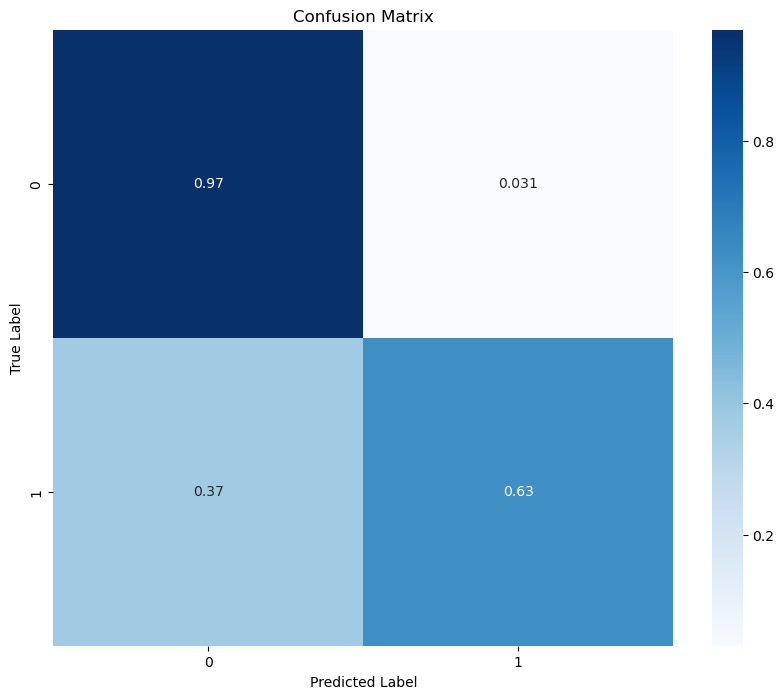

              precision    recall  f1-score   support

       False       0.97      0.97      0.97    391971
        True       0.63      0.63      0.63     32107

    accuracy                           0.94    424078
   macro avg       0.80      0.80      0.80    424078
weighted avg       0.94      0.94      0.94    424078

Precision: 0.9532
Recall: 0.6254
F1 Score: 0.7553


In [18]:
true_labels = np.array(true_labels) == 1

# Step 5: Create confusion matrix
cm = confusion_matrix(true_labels, binary_predictions, normalize='true')

# Step 6: Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(true_labels, binary_predictions))

# Calculate and print additional metrics
true_positives = cm[1, 1]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_negatives = cm[0, 0]

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")